This notebook: take an output parquet file created by extract.py and make plots

In [1]:
import seaborn as sns
from pathlib import Path
import os
from loguru import logger
import math
import jq
import json
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd
sns.set_style("whitegrid")

In [22]:
exp_id = "psc-baselines-2"
result_filepath = f"../results/{exp_id}.parquet"

In [23]:
results_df = pl.read_parquet(result_filepath)
def value_mapper(s: str):
    if "ms" in s:
        return float(s.replace("ms", ""))
    else:
        assert False
results_df = results_df.with_columns(
    time=pl.col("value").map_elements(value_mapper, return_dtype=pl.Float64)
)
results_df

exp_id,machine_id,dist,size_config,n_rows,n_groups,algorithm,np,trial_id,attribute,value,time
str,str,str,str,i64,i64,str,i64,i64,str,str,f64
"""psc-baselines-2""","""psc""","""uniform""","""80M-20M""",80000000,20000000,"""duckdb""",4,0,"""elapsed_time""","""3638.789ms""",3638.789
"""psc-baselines-2""","""psc""","""uniform""","""80M-20M""",80000000,20000000,"""duckdb""",4,1,"""elapsed_time""","""3451.743ms""",3451.743
"""psc-baselines-2""","""psc""","""uniform""","""80M-20M""",80000000,20000000,"""duckdb""",4,2,"""elapsed_time""","""3317.398ms""",3317.398
"""psc-baselines-2""","""psc""","""uniform""","""80M-20M""",80000000,20000000,"""duckdb""",4,3,"""elapsed_time""","""3476.757ms""",3476.757
"""psc-baselines-2""","""psc""","""uniform""","""80M-20M""",80000000,20000000,"""duckdb""",4,4,"""elapsed_time""","""3532.547ms""",3532.547
…,…,…,…,…,…,…,…,…,…,…,…
"""psc-baselines-2""","""psc""","""biuniform""","""80M-20M""",80000000,20000000,"""two-phase-radix-xxhash""",4,4,"""phase_1""","""3043ms""",3043.0
"""psc-baselines-2""","""psc""","""biuniform""","""80M-20M""",80000000,20000000,"""two-phase-radix-xxhash""",4,4,"""phase_2""","""1101ms""",1101.0
"""psc-baselines-2""","""psc""","""biuniform""","""80M-20M""",80000000,20000000,"""two-phase-radix-xxhash""",4,4,"""aggregation_time""","""4334ms""",4334.0


In [28]:
results_df.sql("""--sql
    select exp_id, machine_id, dist, size_config, n_rows, n_groups, algorithm, np, attribute, avg(time) as avg_time from self 
    where algorithm = 'duckdb'
      and size_config = '80M-200K'
      --and attribute = 'phase_1'
      and dist = 'uniform'
    group by exp_id, machine_id, dist, size_config, n_rows, n_groups, algorithm, np, attribute
    order by np
""")

exp_id,machine_id,dist,size_config,n_rows,n_groups,algorithm,np,attribute,avg_time
str,str,str,str,i64,i64,str,i64,str,f64
"""psc-baselines-2""","""psc""","""uniform""","""80M-200K""",80000000,200000,"""duckdb""",1,"""elapsed_time""",4422.139
"""psc-baselines-2""","""psc""","""uniform""","""80M-200K""",80000000,200000,"""duckdb""",2,"""elapsed_time""",2125.5584
"""psc-baselines-2""","""psc""","""uniform""","""80M-200K""",80000000,200000,"""duckdb""",4,"""elapsed_time""",1886.5894
"""psc-baselines-2""","""psc""","""uniform""","""80M-200K""",80000000,200000,"""duckdb""",8,"""elapsed_time""",1005.6478
"""psc-baselines-2""","""psc""","""uniform""","""80M-200K""",80000000,200000,"""duckdb""",16,"""elapsed_time""",502.429
"""psc-baselines-2""","""psc""","""uniform""","""80M-200K""",80000000,200000,"""duckdb""",32,"""elapsed_time""",295.4918
"""psc-baselines-2""","""psc""","""uniform""","""80M-200K""",80000000,200000,"""duckdb""",64,"""elapsed_time""",236.5354
"""psc-baselines-2""","""psc""","""uniform""","""80M-200K""",80000000,200000,"""duckdb""",128,"""elapsed_time""",302.2934


# Elapsed Time vs np

Text(0.5, 1.03, 'Elapsed Time vs Num Threads')

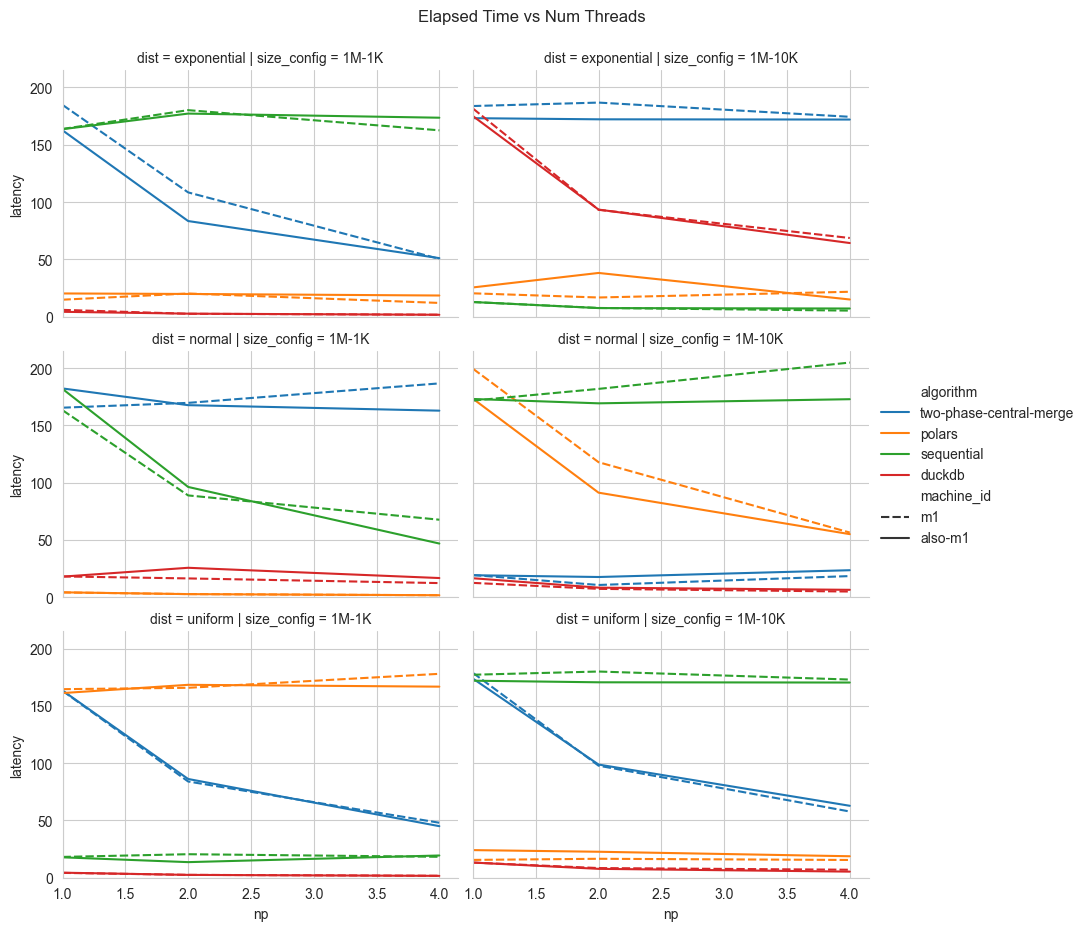

In [ ]:
plot_df = results_df.sql(f"""--sql
    select algorithm, np, size_config, dist, machine_id, avg(time) as latency from self
    where true
        and attribute = 'elapsed_time'
    group by algorithm, np, size_config, dist, machine_id
""")

g = sns.FacetGrid(plot_df, col="size_config", row='dist', height=3, aspect=1.5)
g.map_dataframe(sns.lineplot,     
    x='np',
    y='latency',
    hue='algorithm',
    style='machine_id',
)
g.set(xlim=(1, None), ylim=(0, None))
g.add_legend()
g.figure.suptitle("Elapsed Time vs Num Threads", y=1.03)
g.figure.savefig(f"../results/{exp_id}-latency.pdf")